In [ ]:
!pip install segmentation_models_pytorch
!pip install torchmetrics
!pip install thop

In [ ]:
import os
import numpy as np
import zipfile
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
import segmentation_models_pytorch as smp

from tqdm.notebook import tqdm
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
zip_depth_ir_pm_path = '/content/drive/MyDrive/SKKU_2-2 URP/[2] Pressure_Sore_Dataset/SLP_Dataset_RGB_PM/Depth_IR_PM.zip'
unzip_depth_ir_pm_path = '/content/Depth_IR_PM'

os.makedirs(unzip_depth_ir_pm_path, exist_ok=True)
with zipfile.ZipFile(zip_depth_ir_pm_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_depth_ir_pm_path)

# **Dataset**

In [ ]:
class IR_PM_Dataset(Dataset):
    def __init__(self, ir_folder, pm_folder, transform):
        """
        적외선(IR) 이미지와 압력맵(PM) 이미지를 불러와서 변환하는 데이터셋 클래스입니다.
        """
        self.ir_folder = ir_folder
        self.pm_folder = pm_folder

        self.ir_images = sorted(os.listdir(self.ir_folder))
        self.pm_images = sorted(os.listdir(self.pm_folder))

        self.transform = transform

    def __len__(self):
        return len(self.pm_images)

    def __getitem__(self, idx):
        """
        적외선 이미지와 압력맵 이미지를 불러와서 정규화 및 스케일링을 진행하고 반환합니다.
        """
        # ir image
        ir_path = os.path.join(self.ir_folder, self.ir_images[idx])
        ir_img = Image.open(ir_path).convert('RGB')
        ir_img = self.normalize_scale(ir_img) # 정규화 및 스케일링

        # Pressure map
        pm_path = os.path.join(self.pm_folder, self.pm_images[idx])
        pm_img = Image.open(pm_path)
        pm_img = self.normalize_scale(pm_img) # 정규화 및 스케일링

        ir_img, pm_img = self.transform(ir_img), self.transform(pm_img)
        return ir_img, pm_img

    def normalize_scale(self, img):
        """
        적외선 이미지에서는 사람과 배경 간의 밝기 차이가 나타날 수 있도록 밝기 조정을 수행합니다.
        또한, 압력맵 이미지에서도 배경(압력이 없는 곳)과 사람(압력이 있는 곳) 간의 압력 차이가 명확히 나타날 수 있도록 밝기 조정을 수행합니다.
        """
        img = np.array(img)
        img = (img - img.min()) / (img.max() - img.min() + 1e-8) # [0, 1] 범위로 정규화

        # 압력맵 이미지
        if len(img.shape) == 2:
            img = np.power(img, 0.5)

        # 적외선 이미지
        else:
            img = np.power(img, 0.75)

        # 이미지 픽셀 값을 0~255 사이로 클리핑 후, 정수형으로 변환
        img = np.clip(img * 255, 0, 255).astype(np.uint8)
        return img

In [ ]:
ir_path = '/content/Depth_IR_PM/IR_png'
pm_path = '/content/Depth_IR_PM/PM_png'

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((192, 96))])

dataset = IR_PM_Dataset(ir_path, pm_path, transform)

In [ ]:
"""
훈련 데이터 크기: 전체 데이터셋의 80%
검증 데이터 크기: 전체 데이터셋의 10%
테스트 데이터 크기: 전체 데이터셋의 10%
"""

data_size = len(dataset)
train_size = int(data_size * 0.8)
val_size = int(data_size * 0.1)
test_size = data_size - train_size - val_size

train_indices = list(range(0, train_size))
val_indices = list(range(train_size, val_size + train_size))
test_indices = list(range(val_size + train_size, data_size))

In [ ]:
print('Train samples:', train_size)
print('Val samples:', val_size)
print('Test samples:', test_size)

Train samples: 10800
Val samples: 1350
Test samples: 1350


In [ ]:
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

In [ ]:
"""
훈련 데이터가 약 1만장이므로, 배치 크기는 32로 설정
"""

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

Infrared image shape: torch.Size([3, 192, 96])
Pressure map shape: torch.Size([1, 192, 96])


Text(0.5, 1.0, 'Pressure Map (Ground Truth)')

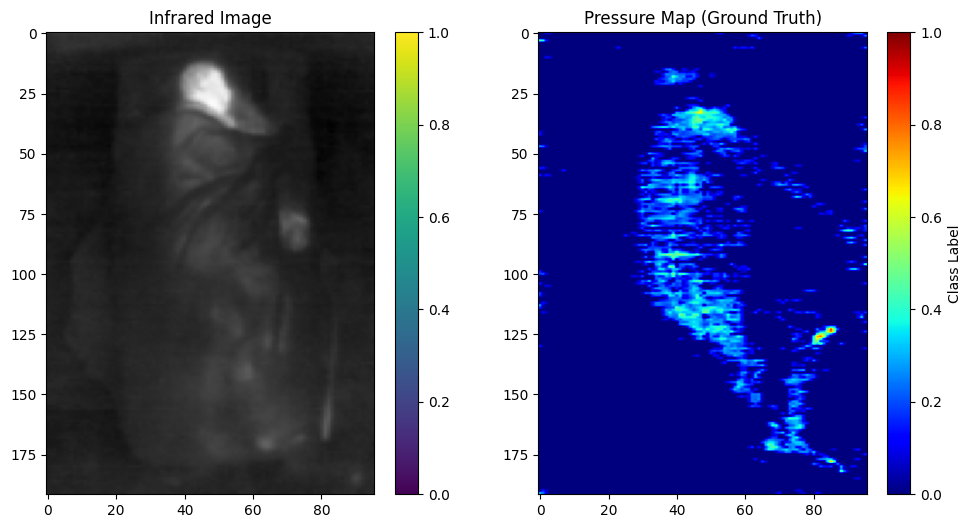

In [ ]:
ir_sample, pm_sample = next(iter(train_loader))

ir_sample = ir_sample[0]
pm_sample = pm_sample[0]

print('Infrared image shape:', ir_sample.shape)
print('Pressure map shape:', pm_sample.shape)

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(ir_sample.permute(1, 2, 0), cmap='viridis', vmin=0, vmax=1, aspect='auto')
plt.colorbar()
plt.title('Infrared Image')

plt.subplot(1, 3, 2)
plt.imshow(pm_sample.squeeze(0), cmap='jet', vmin=0, vmax=1, aspect='auto')
plt.colorbar(label='Class Label')
plt.title('Pressure Map (Ground Truth)')

# **Model**

In [ ]:
"""
U-Net 모델을 생성
encoder_name="resnet50": U-Net의 백본으로 ResNet50을 사용
encoder_weights="imagenet": ResNet50의 가중치는 ImageNet에서 학습된 가중치를 사용
in_channels=3: 입력 이미지 채널 수 (RGB 이미지이므로 3)
classes=1: 출력 클래스 수 (압력값에 대한 회귀 예측이므로 클래스 수는 1)

모델은 다음과 같이 바꾸어서 사용.
smp.Unet()
smp.UnetPlusPlus()
smp.FPN()
smp.DeepLabV3()
smp.DeepLabV3Plus()
smp.MAnet()

또한, encoder_name은 "resnet50" 또는 "resnet34"를 사용
"""
model = smp.Unet(encoder_name="resnet50", encoder_weights="imagenet", in_channels=3, classes=1)

In [ ]:
print(model)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [ ]:
# 모델의 전체 파라미터 수 계산
total_params = sum(p.numel() for p in model.parameters())

# 학습 가능한 파라미터 수 계산 (requires_grad=True인 파라미터들만 계산)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 32521105
Trainable parameters: 32521105


In [ ]:
from thop import profile

input_data = torch.randn(1, 3, 192, 96)
flops, params = profile(model, inputs=(input_data, ))

print(f"FLOPs: {flops / 1e9:.2f} G-Ops")
print(f"Parameters: {params / 1e6:.2f} M")

In [ ]:
model = model.to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure

# RMSE (Root Mean Squared Error) 계산 함수
def RMSE(y_pred, y_true):
    return torch.sqrt(F.mse_loss(y_pred, y_true))

In [ ]:
def train(model, data_loader, criterion, optimizer):
    # SSIM 지표 객체 생성 (데이터 범위 1.0 설정)
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

    model.train()
    train_loss = 0.0
    train_rmse = 0.0
    train_ssim = 0.0

    for inputs, labels in tqdm(data_loader, desc='Training', leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        rmse = RMSE(outputs, labels)
        train_rmse += rmse.item()

        ssim_score = ssim_metric(outputs, labels)
        train_ssim += ssim_score.item()

    train_loss /= len(data_loader)
    train_rmse /= len(data_loader)
    train_ssim /= len(data_loader)

    return train_loss, train_rmse, train_ssim

In [ ]:
def evaluate(model, data_loader, criterion):
    # SSIM 지표 객체 생성 (데이터 범위 1.0 설정)
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

    model.eval()
    eval_loss = 0.0
    eval_rmse = 0.0
    eval_ssim = 0.0

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc='Evaluating', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            eval_loss += loss.item()

            rmse = RMSE(outputs, labels)
            eval_rmse += rmse.item()

            ssim_score = ssim_metric(outputs, labels)
            eval_ssim += ssim_score.item()

    eval_loss /= len(data_loader)
    eval_rmse /= len(data_loader)
    eval_ssim /= len(data_loader)

    return eval_loss, eval_rmse, eval_ssim

In [ ]:
num_epochs = 50
train_results = {'Loss': [], 'RMSE': [], 'SSIM': []}
val_results = {'Loss': [], 'RMSE': [], 'SSIM': []}

for epoch in range(num_epochs):
    start_time = time.time()

    train_loss, train_rmse, train_ssim = train(model, train_loader, criterion, optimizer)
    val_loss, val_rmse, val_ssim = evaluate(model, val_loader, criterion)

    end_time = time.time()

    train_results['Loss'].append(train_loss)
    val_results['Loss'].append(val_loss)

    train_results['RMSE'].append(train_rmse)
    val_results['RMSE'].append(val_rmse)

    train_results['SSIM'].append(train_ssim)
    val_results['SSIM'].append(val_ssim)

    print(f"[Epoch {epoch + 1}/{num_epochs}, {int(end_time - start_time)}s]")
    print(f"Training Loss: {train_loss:.6f} | RMSE: {train_rmse:.4f} | SSIM: {train_ssim:.4f}")
    print(f"Validation Loss: {val_loss:.6f} | RMSE: {val_rmse:.4f} | SSIM: {val_ssim:.4f}")
    print("=" * 60)
    print()

Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 1/50, 74s]
Training Loss: 0.010250 | RMSE: 0.0872 | SSIM: 0.3653
Validation Loss: 0.007192 | RMSE: 0.0842 | SSIM: 0.4421



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 2/50, 74s]
Training Loss: 0.005557 | RMSE: 0.0745 | SSIM: 0.4849
Validation Loss: 0.006338 | RMSE: 0.0787 | SSIM: 0.5233



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 3/50, 74s]
Training Loss: 0.005149 | RMSE: 0.0717 | SSIM: 0.5191
Validation Loss: 0.005277 | RMSE: 0.0724 | SSIM: 0.5501



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 4/50, 74s]
Training Loss: 0.004744 | RMSE: 0.0688 | SSIM: 0.5425
Validation Loss: 0.006735 | RMSE: 0.0799 | SSIM: 0.5293



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 5/50, 74s]
Training Loss: 0.004436 | RMSE: 0.0666 | SSIM: 0.5647
Validation Loss: 0.008533 | RMSE: 0.0848 | SSIM: 0.5656



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 6/50, 74s]
Training Loss: 0.004161 | RMSE: 0.0645 | SSIM: 0.5841
Validation Loss: 0.010734 | RMSE: 0.0984 | SSIM: 0.5650



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 7/50, 74s]
Training Loss: 0.003940 | RMSE: 0.0627 | SSIM: 0.6017
Validation Loss: 0.016337 | RMSE: 0.1154 | SSIM: 0.5775



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 8/50, 74s]
Training Loss: 0.003775 | RMSE: 0.0614 | SSIM: 0.6135
Validation Loss: 0.006724 | RMSE: 0.0794 | SSIM: 0.5823



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 9/50, 74s]
Training Loss: 0.003598 | RMSE: 0.0600 | SSIM: 0.6217
Validation Loss: 0.004893 | RMSE: 0.0699 | SSIM: 0.5688



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 10/50, 74s]
Training Loss: 0.003577 | RMSE: 0.0598 | SSIM: 0.6244
Validation Loss: 0.005467 | RMSE: 0.0738 | SSIM: 0.6049



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 11/50, 75s]
Training Loss: 0.003393 | RMSE: 0.0582 | SSIM: 0.6415
Validation Loss: 0.009093 | RMSE: 0.0882 | SSIM: 0.6129



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 12/50, 74s]
Training Loss: 0.003276 | RMSE: 0.0572 | SSIM: 0.6482
Validation Loss: 0.004704 | RMSE: 0.0685 | SSIM: 0.6107



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 13/50, 74s]
Training Loss: 0.003173 | RMSE: 0.0563 | SSIM: 0.6501
Validation Loss: 0.007563 | RMSE: 0.0783 | SSIM: 0.6151



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 14/50, 74s]
Training Loss: 0.003143 | RMSE: 0.0560 | SSIM: 0.6596
Validation Loss: 0.005573 | RMSE: 0.0737 | SSIM: 0.5886



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 15/50, 74s]
Training Loss: 0.003060 | RMSE: 0.0553 | SSIM: 0.6629
Validation Loss: 0.004756 | RMSE: 0.0689 | SSIM: 0.6269



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 16/50, 74s]
Training Loss: 0.003349 | RMSE: 0.0575 | SSIM: 0.6394
Validation Loss: 0.004953 | RMSE: 0.0703 | SSIM: 0.5501



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 17/50, 74s]
Training Loss: 0.004187 | RMSE: 0.0646 | SSIM: 0.5783
Validation Loss: 0.004683 | RMSE: 0.0684 | SSIM: 0.6221



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 18/50, 74s]
Training Loss: 0.003431 | RMSE: 0.0585 | SSIM: 0.6368
Validation Loss: 0.004681 | RMSE: 0.0684 | SSIM: 0.6263



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 19/50, 74s]
Training Loss: 0.003135 | RMSE: 0.0560 | SSIM: 0.6587
Validation Loss: 0.004715 | RMSE: 0.0686 | SSIM: 0.5828



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 20/50, 74s]
Training Loss: 0.002948 | RMSE: 0.0543 | SSIM: 0.6742
Validation Loss: 0.004683 | RMSE: 0.0684 | SSIM: 0.6242



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 21/50, 74s]
Training Loss: 0.002802 | RMSE: 0.0529 | SSIM: 0.6891
Validation Loss: 0.004797 | RMSE: 0.0692 | SSIM: 0.6528



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 22/50, 74s]
Training Loss: 0.002724 | RMSE: 0.0522 | SSIM: 0.6943
Validation Loss: 0.005412 | RMSE: 0.0733 | SSIM: 0.6061



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 23/50, 74s]
Training Loss: 0.002724 | RMSE: 0.0522 | SSIM: 0.6929
Validation Loss: 0.004829 | RMSE: 0.0695 | SSIM: 0.6268



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 24/50, 74s]
Training Loss: 0.002608 | RMSE: 0.0510 | SSIM: 0.7045
Validation Loss: 0.004848 | RMSE: 0.0696 | SSIM: 0.6054



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 25/50, 74s]
Training Loss: 0.002514 | RMSE: 0.0501 | SSIM: 0.7097
Validation Loss: 0.004767 | RMSE: 0.0690 | SSIM: 0.6613



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 26/50, 74s]
Training Loss: 0.002472 | RMSE: 0.0497 | SSIM: 0.7180
Validation Loss: 0.004722 | RMSE: 0.0687 | SSIM: 0.6163



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 27/50, 74s]
Training Loss: 0.002790 | RMSE: 0.0527 | SSIM: 0.6828
Validation Loss: 0.004770 | RMSE: 0.0690 | SSIM: 0.6440



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 28/50, 74s]
Training Loss: 0.002446 | RMSE: 0.0494 | SSIM: 0.7221
Validation Loss: 0.004706 | RMSE: 0.0686 | SSIM: 0.6569



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 29/50, 74s]
Training Loss: 0.002286 | RMSE: 0.0478 | SSIM: 0.7334
Validation Loss: 0.004858 | RMSE: 0.0697 | SSIM: 0.6591



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 30/50, 74s]
Training Loss: 0.002209 | RMSE: 0.0470 | SSIM: 0.7403
Validation Loss: 0.004795 | RMSE: 0.0692 | SSIM: 0.6584



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 31/50, 74s]
Training Loss: 0.002166 | RMSE: 0.0465 | SSIM: 0.7436
Validation Loss: 0.004823 | RMSE: 0.0694 | SSIM: 0.6623



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 32/50, 74s]
Training Loss: 0.002115 | RMSE: 0.0460 | SSIM: 0.7506
Validation Loss: 0.004718 | RMSE: 0.0686 | SSIM: 0.6666



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 33/50, 74s]
Training Loss: 0.002166 | RMSE: 0.0465 | SSIM: 0.7462
Validation Loss: 0.004863 | RMSE: 0.0697 | SSIM: 0.6690



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 34/50, 74s]
Training Loss: 0.002060 | RMSE: 0.0454 | SSIM: 0.7579
Validation Loss: 0.004750 | RMSE: 0.0689 | SSIM: 0.6511



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 35/50, 74s]
Training Loss: 0.002015 | RMSE: 0.0449 | SSIM: 0.7606
Validation Loss: 0.004790 | RMSE: 0.0692 | SSIM: 0.6732



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 36/50, 74s]
Training Loss: 0.002031 | RMSE: 0.0450 | SSIM: 0.7575
Validation Loss: 0.004803 | RMSE: 0.0693 | SSIM: 0.6380



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 37/50, 74s]
Training Loss: 0.001973 | RMSE: 0.0444 | SSIM: 0.7640
Validation Loss: 0.004932 | RMSE: 0.0702 | SSIM: 0.6349



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 38/50, 74s]
Training Loss: 0.001931 | RMSE: 0.0439 | SSIM: 0.7694
Validation Loss: 0.006702 | RMSE: 0.0818 | SSIM: 0.4381



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 39/50, 74s]
Training Loss: 0.003607 | RMSE: 0.0598 | SSIM: 0.6304
Validation Loss: 0.004765 | RMSE: 0.0690 | SSIM: 0.6247



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 40/50, 74s]
Training Loss: 0.002381 | RMSE: 0.0488 | SSIM: 0.7288
Validation Loss: 0.004773 | RMSE: 0.0690 | SSIM: 0.6558



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 41/50, 74s]
Training Loss: 0.002046 | RMSE: 0.0452 | SSIM: 0.7572
Validation Loss: 0.004813 | RMSE: 0.0693 | SSIM: 0.6592



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 42/50, 74s]
Training Loss: 0.001906 | RMSE: 0.0436 | SSIM: 0.7651
Validation Loss: 0.004768 | RMSE: 0.0690 | SSIM: 0.6670



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 43/50, 74s]
Training Loss: 0.001826 | RMSE: 0.0427 | SSIM: 0.7720
Validation Loss: 0.004824 | RMSE: 0.0694 | SSIM: 0.6690



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 44/50, 74s]
Training Loss: 0.001791 | RMSE: 0.0423 | SSIM: 0.7779
Validation Loss: 0.004917 | RMSE: 0.0701 | SSIM: 0.6454



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 45/50, 74s]
Training Loss: 0.001745 | RMSE: 0.0418 | SSIM: 0.7829
Validation Loss: 0.004844 | RMSE: 0.0696 | SSIM: 0.6695



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 46/50, 74s]
Training Loss: 0.001737 | RMSE: 0.0417 | SSIM: 0.7805
Validation Loss: 0.004931 | RMSE: 0.0702 | SSIM: 0.6606



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 47/50, 74s]
Training Loss: 0.001696 | RMSE: 0.0412 | SSIM: 0.7856
Validation Loss: 0.004860 | RMSE: 0.0697 | SSIM: 0.6722



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 48/50, 74s]
Training Loss: 0.001662 | RMSE: 0.0408 | SSIM: 0.7876
Validation Loss: 0.004919 | RMSE: 0.0701 | SSIM: 0.6712



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 49/50, 74s]
Training Loss: 0.001636 | RMSE: 0.0404 | SSIM: 0.7937
Validation Loss: 0.004831 | RMSE: 0.0695 | SSIM: 0.6740



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 50/50, 74s]
Training Loss: 0.001618 | RMSE: 0.0402 | SSIM: 0.7901
Validation Loss: 0.004835 | RMSE: 0.0695 | SSIM: 0.6666



In [ ]:
test_loss, test_rmse, test_ssim = evaluate(model, test_loader, criterion)

print(f"Test Loss: {test_loss:.6f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test SSIM: {test_ssim:.4f}")

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Test Loss: 0.005358
Test RMSE: 0.0730
Test SSIM: 0.6470


## **Result - Metrics (Loss, RMSE, SSIM)**

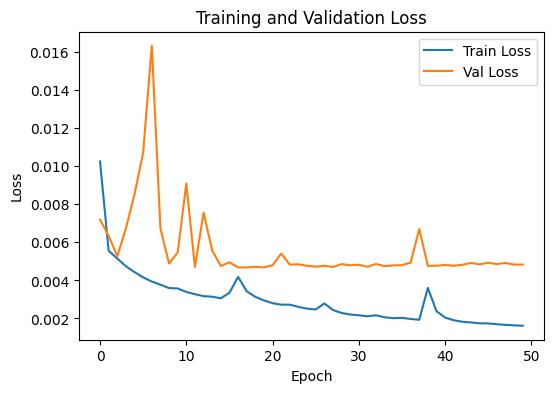

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(train_results['Loss'], label='Train Loss')
plt.plot(val_results['Loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

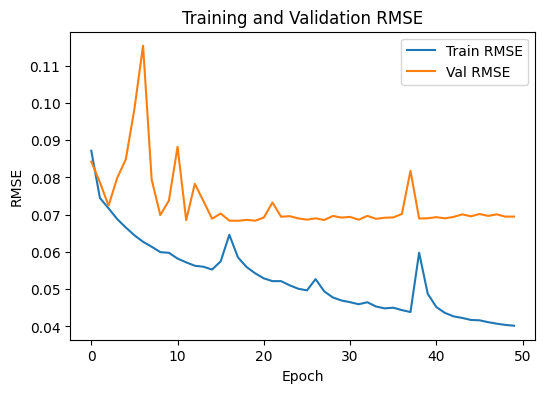

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(train_results['RMSE'], label='Train RMSE')
plt.plot(val_results['RMSE'], label='Val RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Training and Validation RMSE')
plt.legend()
plt.show()

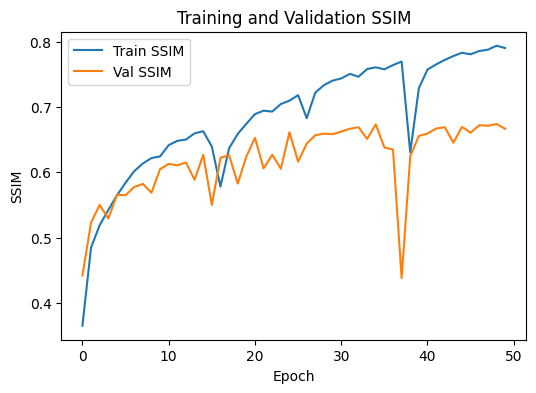

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(train_results['SSIM'], label='Train SSIM')
plt.plot(val_results['SSIM'], label='Val SSIM')
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.title('Training and Validation SSIM')
plt.legend()
plt.show()

# **Results - Prediction image**

In [ ]:
save_path = '/content/drive/MyDrive/SKKU_2-2 URP/[2] Pressure_Sore_Code/model_save/IR_PM_save (색 대비, 최종본)/U-Net(ResNet50)_E50.pth'
checkpoint = torch.load(save_path)

model = smp.Unet(encoder_name="resnet50", encoder_weights="imagenet", in_channels=3, classes=1)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)

In [ ]:
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure

# RMSE (Root Mean Squared Error) 계산 함수
def RMSE(y_pred, y_true):
    return torch.sqrt(F.mse_loss(y_pred, y_true))

In [ ]:
# 모델 예측 결과를 시각화하는 함수
def visualize_result(model, data_loader, is_data = 'Train'):
    # 데이터 로더의 첫번째 배치의 첫번째 데이터를 사용
    ir, pm_gt = next(iter(data_loader))
    ir = ir[0]
    pm_gt = pm_gt[0]

    with torch.no_grad():
        model.eval()

        ir = ir.unsqueeze(0).to(device)
        pm_pred = model(ir)
        pm_pred = pm_pred.cpu()

    # 성능 지표: SSIM 및 RMSE
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
    rmse = RMSE(pm_pred, pm_gt.unsqueeze(0)).item()
    ssim = ssim_metric(pm_pred, pm_gt.unsqueeze(0)).item()

    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(ir.squeeze(0).permute(1, 2, 0).cpu(), aspect='auto')
    plt.colorbar()

    if is_data == 'Train':
        plt.title('Infrared Image (Train)')
    elif is_data == 'Val':
        plt.title('Infrared Image (Validation)')
    elif is_data == 'Test':
        plt.title('Infrared Image (Test)')

    plt.subplot(1, 3, 2)
    plt.imshow(pm_gt.squeeze(0), cmap='jet', vmin=0, vmax=1, aspect='auto')
    plt.colorbar(label='Class Label')
    plt.title('Pressure Map (Ground Truth)')

    plt.subplot(1, 3, 3)
    plt.imshow(pm_pred.squeeze().numpy(), cmap='jet', vmin=0, vmax=1, aspect='auto')
    plt.colorbar(label='Class Label')
    plt.title(f'Pressure Map (Prediction)\nRMSE: {rmse:.4f}, SSIM: {ssim:.4f}')

    plt.tight_layout()
    plt.show()

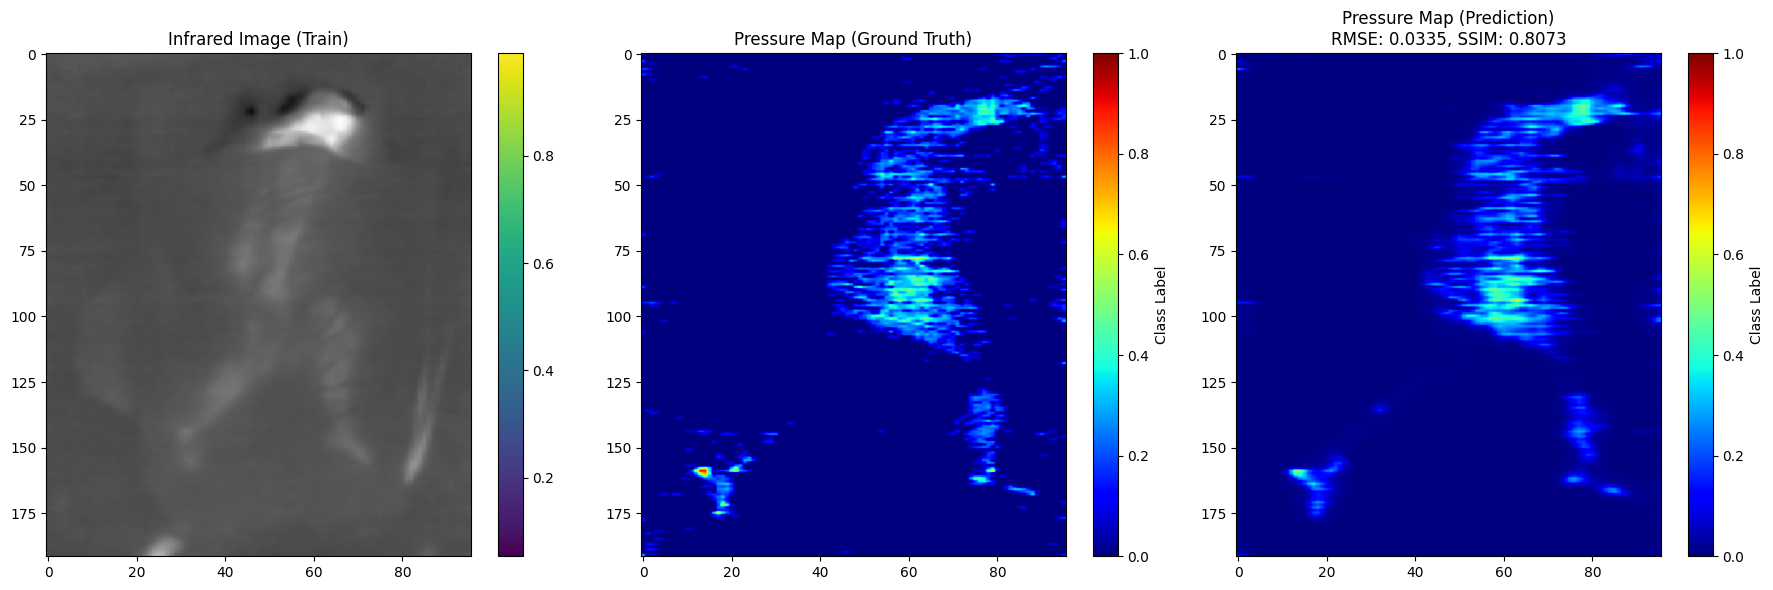

In [ ]:
# 훈련 데이터에 대한 결과 시각화
visualize_result(model, train_loader, 'Train')

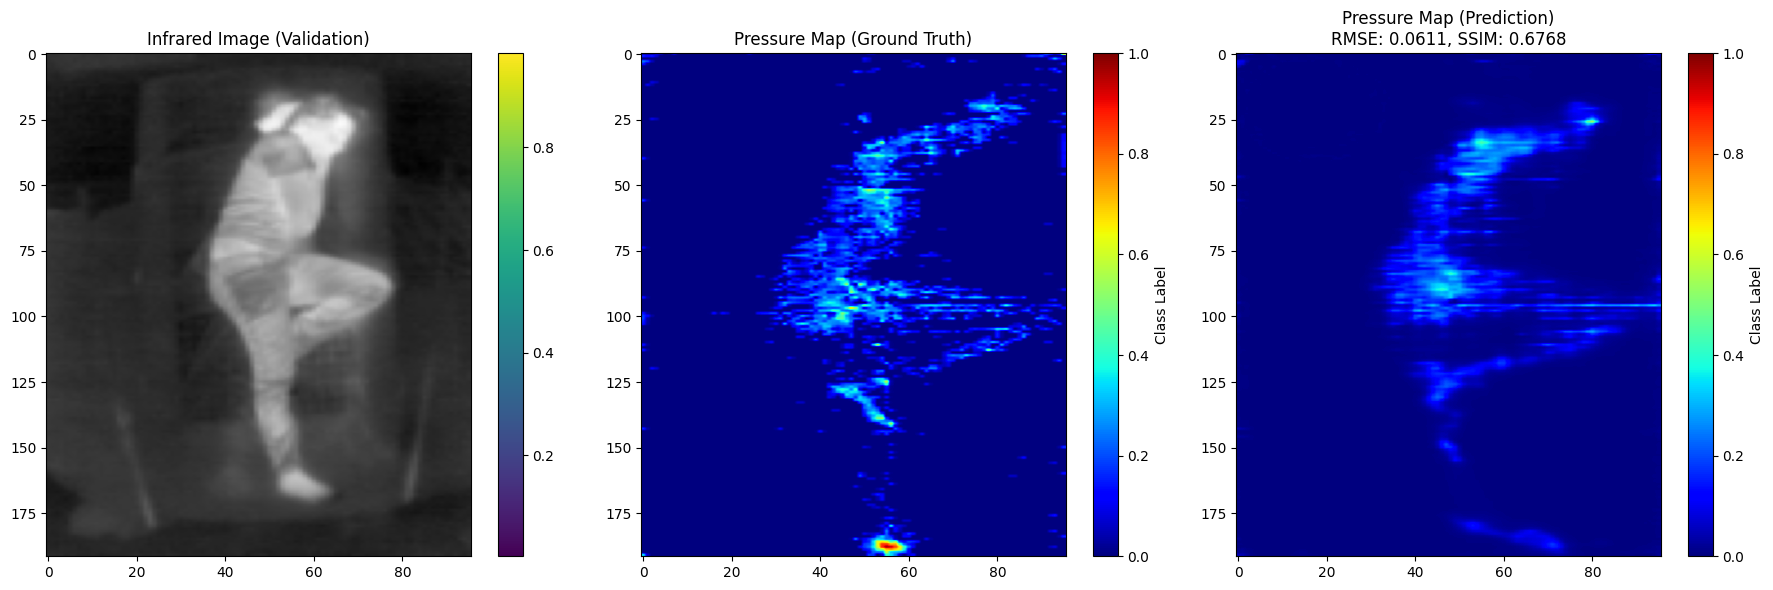

In [ ]:
# 검증 데이터에 대한 결과 시각화
visualize_result(model, val_loader, 'Val')

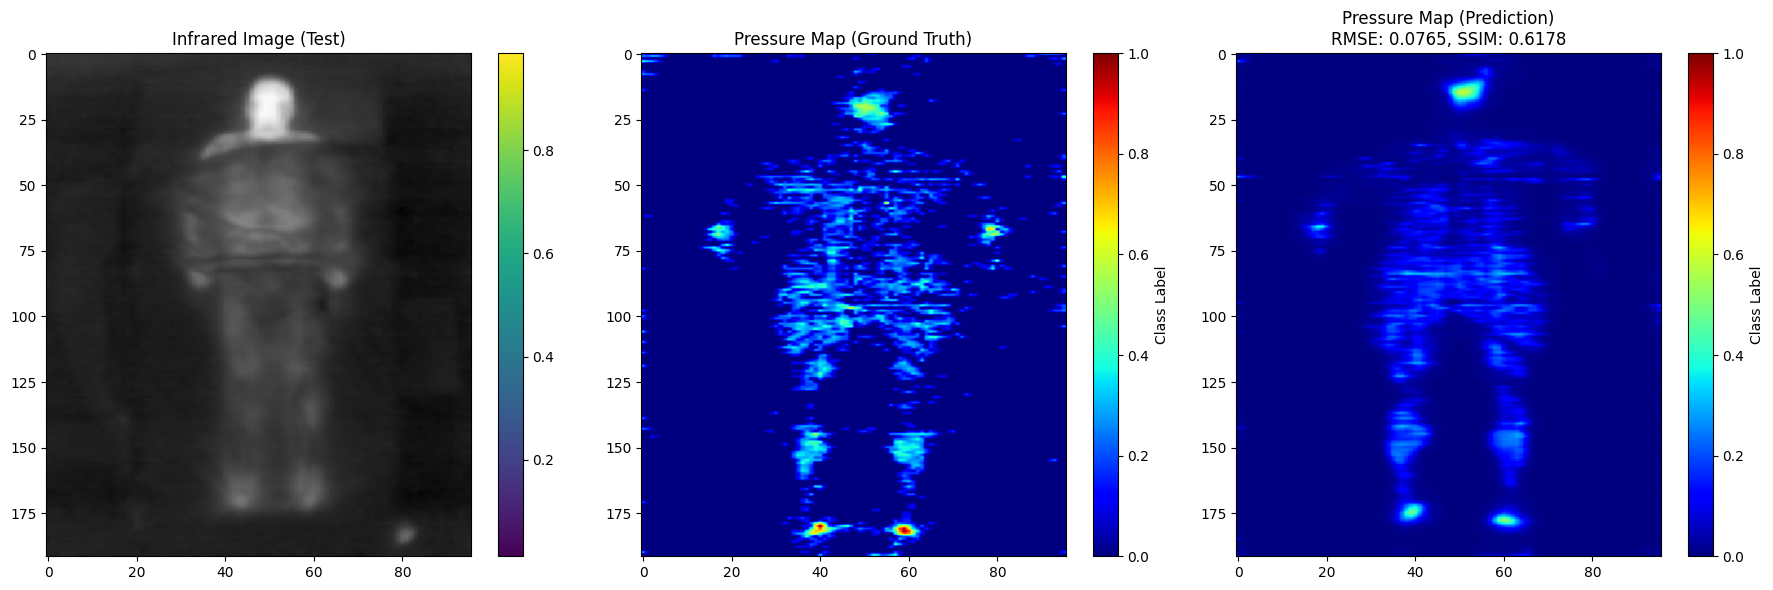

In [ ]:
# 테스트 데이터에 대한 결과 시각화
visualize_result(model, test_loader, 'Test')

In [ ]:
save_path = '/content/drive/MyDrive/SKKU_2-2 URP/[2] Pressure_Sore_Code/model_save/IR_PM_save (색 대비, 최종본)'
checkpoint_path = os.path.join(save_path, 'U-Net(ResNet50)_E50.pth')

if not os.path.exists(checkpoint_path):
    torch.save({'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()}, checkpoint_path)
    print('model save 완료.')
else:
    print('model save 이미 완료.')

model save 이미 완료.
